In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
F=np.array([[3.34638533e-07,  7.58547151e-06, -2.04147752e-03],
   [-5.83765868e-06,  1.36498636e-06, 2.67566877e-04],
   [1.45892349e-03, -4.37648316e-03,  1.00000000e+00]])

In [3]:
current_dir = os.getcwd()

image_filename = "000000.png"  
image_path = os.path.join(current_dir, image_filename)
left_image = cv2.imread(image_path)
right_image = os.path.join(current_dir, "000023.png")
right_image = cv2.imread(right_image)


In [4]:
class EpipolarLines:
    def __init__(self, left_image,right_image,F):
        self.left_image = left_image
        self.right_image = right_image
        self.det = cv2.SIFT_create()
        self.F = F
        
    def detectandmatch(self):
        k1,des1 = self.det.detectAndCompute(self.left_image,None)
        k2,des2 = self.det.detectAndCompute(self.right_image,None)
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=2)
        filtered_matches = []
        for m,n in matches:
            ratio = m.distance/n.distance
            if ratio <= 0.5:
                filtered_matches.append(m)
        self.kp1 = np.array([k1[match.queryIdx].pt for match in filtered_matches]).astype(int)
        self.kp2 = np.array([k2[match.trainIdx].pt for match in filtered_matches]).astype(int)
        hom_kp1 = np.hstack((self.kp1, np.ones((self.kp1.shape[0],1), dtype = int))).astype(int)
        hom_kp2 = np.hstack((self.kp2, np.ones((self.kp2.shape[0],1), dtype=int))).astype(int)
        return hom_kp1, hom_kp2
    
    def first_image_points(self,num_points=10):
        left_image_copy, right_image_copy = self.left_image.copy(), self.right_image.copy()
        hom_kp1, hom_kp2 = self.detectandmatch()
        right_epipolar = np.dot(self.F,hom_kp1[0].T)
        left_epipolar = np.dot(self.F.T, hom_kp2[0].T)
        x0_r, y0_r = 0, int(-right_epipolar[2]/right_epipolar[1])
        x1_r, y1_r = right_image_copy.shape[1], int(-(right_epipolar[0]*right_image_copy.shape[1] + right_epipolar[2])/right_epipolar[1])
        
        x0_l, y0_l = 0, int(-left_epipolar[2]/left_epipolar[1])
        x1_l, y1_l = left_image_copy.shape[1], int(-(left_epipolar[0]*left_image_copy.shape[1] + left_epipolar[2])/left_epipolar[1])
        epipolar_line_length = np.sqrt((x1_l - x0_l)**2 + (y1_l - y0_l)**2)
        spacing = epipolar_line_length / (num_points + 1)

        pts_on_left_epipolar =[]

        for j in range(1,num_points+1):
            x1 = x0_l + j*(spacing-5)
            y1 = -(left_epipolar[2]+left_epipolar[0]*x1)/left_epipolar[1]
            pts_on_left_epipolar.append((x1,y1))
            cv2.circle(left_image_copy,[int(x1),int(y1)],5,(255,0,255),-1)
        for point in pts_on_left_epipolar:
            x1,y1 = point
            y2 = -(right_epipolar[2]+right_epipolar[0]*x1)/right_epipolar[1]
            cv2.circle(right_image_copy,[int(x1),int(y2)],5,(255,0,255),-1)
            
        cv2.line(right_image_copy, (x0_r, y0_r), (int(x1_r), int(y1_r)), (255, 0, 0), 2)
        cv2.line(left_image_copy, (x0_l, y0_l), (int(x1_l), int(y1_l)), (255, 0, 0), 2)
        right_image_copy = cv2.cvtColor(right_image_copy, cv2.COLOR_BGR2RGB)
        left_image_copy = cv2.cvtColor(left_image_copy, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(20,10 ))
        plt.subplot(121)
        plt.imshow(left_image_copy)
        plt.title('Left Image')
        plt.subplot(122)
        plt.imshow(right_image_copy)
        plt.title('Right Image')
        plt.show()
    
    def second_image_points(self,num_points=10):
        left_image_copy = self.left_image.copy()
        right_image_copy = self.right_image.copy()
        hom_kp1, hom_kp2 = self.detectandmatch()
        right_epipolar = np.dot(self.F,hom_kp1[1].T)
        left_epipolar = np.dot(self.F.T, hom_kp2[1].T)
        x0_r, y0_r = 0, int(-right_epipolar[2]/right_epipolar[1])
        x1_r, y1_r = right_image.shape[1], int(-(right_epipolar[0]*right_image.shape[1] + right_epipolar[2])/right_epipolar[1])
        x0_l, y0_l = 0, int(-left_epipolar[2]/left_epipolar[1])
        x1_l, y1_l = right_image.shape[1], int(-(left_epipolar[0]*right_image.shape[1] + left_epipolar[2])/left_epipolar[1])
        pts_on_right_epipolar =[]
        epipolar_line_length = np.sqrt((x1_r - x0_r)**2 + (y1_r - y0_r)**2)
        spacing = epipolar_line_length / (num_points + 1)
    
        for j in range(1,num_points+1):
            x1 = x0_r+j*(spacing-5)
            y1 = -(right_epipolar[2]+right_epipolar[0]*x1)/right_epipolar[1]
            pts_on_right_epipolar.append((x1,y1))
            cv2.circle(right_image_copy,[int(x1),int(y1)],5,(0,0,255),-1)
        for point in pts_on_right_epipolar:
            x1,y1 = point
            y2 = -(left_epipolar[2]+left_epipolar[0]*x1)/left_epipolar[1]
            cv2.circle(left_image_copy,[int(x1),int(y2)],5,(0,0,255),-1)
            
        cv2.line(right_image_copy, (x0_r, y0_r), (int(x1_r), int(y1_r)), (0, 255, 0), 2)
        cv2.line(left_image_copy, (x0_l, y0_l), (int(x1_l), int(y1_l)), (0, 255, 0), 2)
        left_image_copy = cv2.cvtColor(left_image_copy, cv2.COLOR_BGR2RGB)
        right_image_copy = cv2.cvtColor(right_image_copy, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(20,10 ))
        plt.subplot(121)
        plt.imshow(left_image_copy)
        plt.title('Left Image')
        plt.subplot(122)
        plt.imshow(right_image_copy)
        plt.title('Right Image')
        plt.show()
        
                
        
    def display_all_epipolar_lines(self):
        hom_kp1, hom_kp2 = self.detectandmatch()
        left_image_copy = self.left_image.copy()
        right_image_copy = self.right_image.copy()
        for i in range(hom_kp1.shape[0]):
            self.right_epipolar = np.dot(self.F,hom_kp1[i].T)
            x0_r, y0_r = 0, int(-self.right_epipolar[2]/self.right_epipolar[1])
            x1_r, y1_r = right_image.shape[1], int(-(self.right_epipolar[0]*right_image.shape[1] + self.right_epipolar[2])/self.right_epipolar[1])
            cv2.line(right_image_copy, (x0_r, y0_r), (x1_r, y1_r), (0, 255, 0), 2)

            self.left_epipolar = np.dot(self.F.T, hom_kp2[i].T)
            x0_l, y0_l = 0, int(-self.left_epipolar[2]/self.left_epipolar[1])
            x1_l, y1_l = left_image.shape[1], int(-(self.left_epipolar[0]*left_image.shape[1] + self.left_epipolar[2])/self.left_epipolar[1])
            cv2.line(left_image_copy, (x0_l, y0_l), (x1_l, y1_l), (255, 0,0), 2)
            
            cv2.circle(left_image_copy, [self.kp1[i][0],self.kp1[i][1]], 5, (0, 0, 255), -1)  # Highlight the selected point on the left image
            cv2.circle(right_image_copy, [self.kp2[i][0], self.kp2[i][1]], 5, (255,0,0), -1)
        left_image_copy = cv2.cvtColor(left_image_copy, cv2.COLOR_BGR2RGB)
        right_image_copy = cv2.cvtColor(right_image_copy, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(20,10 ))

        plt.subplot(121)
        plt.imshow(left_image_copy)
        plt.title('Left Image')
        plt.subplot(122)
        plt.imshow(right_image_copy)
        plt.title('Right Image')
        plt.show()

In [5]:
epl = EpipolarLines(left_image,right_image,F)


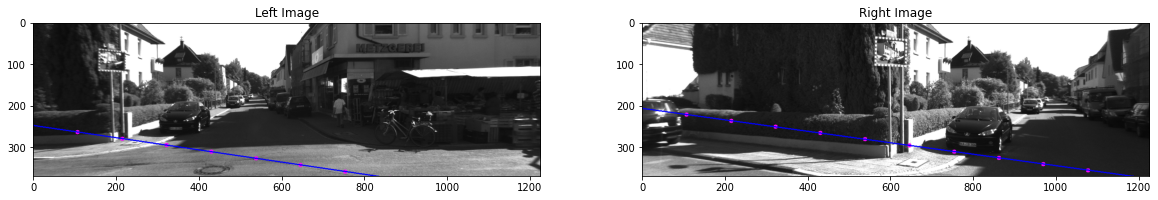

In [8]:
epl.first_image_points()

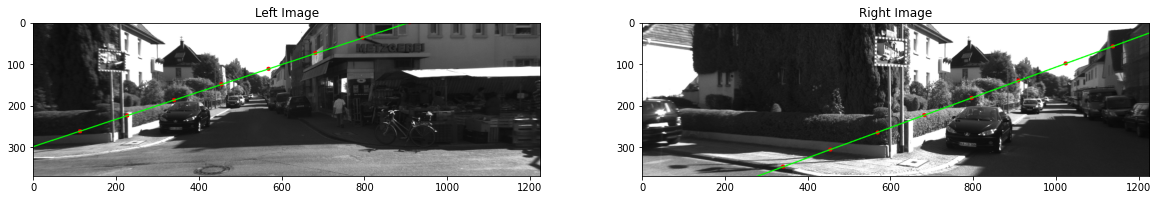

In [14]:
epl.second_image_points()

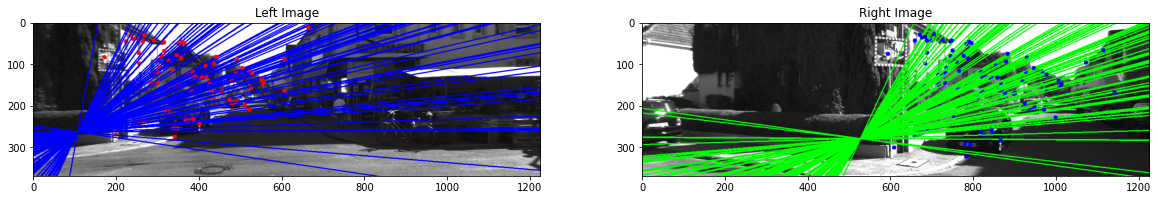

In [90]:
epl.display_all_epipolar_lines()